In [2]:
import dask.dataframe as dd
import matplotlib.pyplot as plt
import numpy as np
from pathlib import Path
import pandas as pd
from datetime import datetime
import os
import cv2
import matplotlib.pyplot as plt

class Lettore:
    def __init__(self, filepth, frame_size = (144,112)):
        self.pth = filepth
        self.frame_size = frame_size

    def __enter__(self):
        self.file_img = open( os.path.join( self.pth, 'img.csv' ) , 'r') 
        self.file_label = open(os.path.join( self.pth, 'label.csv' ), 'r') 
        self.file_beh = open(os.path.join( self.pth, 'label_beh.csv' ), 'r') 
        
        # reading header
        line = self.file_img.readline() 
        line = self.file_label.readline() 
        lineb = self.file_beh.readline() 
        
        line = line.strip()
        self.header = dict( [i.split(':') for i in line[1:].split(';')] )
        self.header['ROI_x'] = int(self.header['ROI_x'])
        self.header['ROI_y'] = int(self.header['ROI_y'])
        
        return self
    
    def getFrameNext(self):
        line_img = self.file_img.readline() 
        line_lbl = self.file_label.readline()
        line_beh = self.file_beh.readline()
        
        if line_img:
            line_img = line_img.strip()
            line_lbl = line_lbl.strip()
            line_beh = line_beh.strip()
            
            if line_img[-1]==';':
                array_img = np.array(line_img[:-1].split(';'), dtype=np.float32)
            else:
                array_img = np.array(line_img.split(';'), dtype=np.float32)
                
            if line_lbl[-1]==';':
                array_lbl = np.array(line_lbl[:-1].split(';'), dtype=np.float32)
            else:
                array_lbl = np.array(line_lbl.split(';'), dtype=np.float32)
            
            if line_beh[-1]==';':
                beh = line_beh[:-1].split(';')
            else:
                array_beh = line_beh.split(';')

            frame_id = array_img[0]
            lbl_id = array_lbl[0]
            beh_id = np.float32(array_beh[0])
            
            if not(frame_id == lbl_id and lbl_id== beh_id and frame_id == beh_id):
                print('######### WARNING: ID mismatch ##########')
                print(frame_id, lbl_id, beh_id,'=',frame_id - lbl_id - beh_id)
            
            frame = array_img[1:].reshape([self.header['ROI_x'],self.header['ROI_y']])
            lbl = array_lbl[1:].reshape([self.header['ROI_x'],self.header['ROI_y']])
            beh = array_beh[1]
            
            frame = cv2.resize(frame,dsize=self.frame_size,interpolation=cv2.INTER_CUBIC).T
            lbl = cv2.resize(lbl,dsize=self.frame_size,interpolation=cv2.INTER_NEAREST).T
        else:
            frame_id = None
            frame = None
            lbl = None
            beh = None
            
        return frame_id, frame, lbl, beh

    def __exit__(self, exc_type, exc_value, traceback):
        self.file_img.close()
        self.file_label.close()

In [3]:
pth = Path(r'D:\thermography\thermal_behaviour_72_h_clean\data')
content = os.listdir(pth)
content = list(filter(lambda x: (pth/x).is_dir(), content ) ) 

subjects = dict()
for c in content:
    parts = c.split('-')
    sub_id = parts[2]
    if sub_id not in subjects.keys():
        subjects[sub_id] = dict()
        subjects[sub_id]['id'] = parts[2] 
        subject_parts = subjects[sub_id]['id'].split('_')
        subjects[sub_id]['geno'] = subject_parts[0]
        subjects[sub_id]['number'] = subject_parts[1]
        subjects[sub_id]['path'] = (pth/c).as_posix()
        #subjects[sub_id]['img'] = [(pth/c/'img.csv').as_posix()]
    #else:
        #subjects[sub_id]['label'].append( (pth/c/'label.csv').as_posix() )
        #subjects[sub_id]['img'].append( (pth/c/'img.csv').as_posix() )

subjects = pd.DataFrame.from_dict(subjects).T.reset_index(drop=True)
#subjects['img'] = subjects['img'].apply(sorted)

In [4]:
subjects

,id,geno,number,path
0,KO_70,KO,70,D:/thermography/thermal_behaviour_72_h_clean/d...
1,KO_69,KO,69,D:/thermography/thermal_behaviour_72_h_clean/d...
2,WT_74,WT,74,D:/thermography/thermal_behaviour_72_h_clean/d...
3,WT_81,WT,81,D:/thermography/thermal_behaviour_72_h_clean/d...
4,KO_75,KO,75,D:/thermography/thermal_behaviour_72_h_clean/d...
5,KO_72,KO,72,D:/thermography/thermal_behaviour_72_h_clean/d...
6,WT_79,WT,79,D:/thermography/thermal_behaviour_72_h_clean/d...


In [4]:
cv2.namedWindow('img', cv2.WINDOW_NORMAL)
cv2.namedWindow('lbl', cv2.WINDOW_NORMAL)

with Lettore(subjects.loc[6,'path']) as L:
    while True:
        frame_id, frame, lbl, beh = L.getFrameNext()
        if frame_id:
            cv2.imshow('img', frame/np.max(frame) )
            cv2.imshow('lbl', lbl/np.max(lbl) )
        else:
            break
        
        if cv2.waitKey(1) & 0xFF == ord('q'):
            break
cv2.destroyAllWindows()

In [5]:
cv2.destroyAllWindows()

In [5]:
#cv2.namedWindow('img', cv2.WINDOW_NORMAL)
#cv2.namedWindow('lbl', cv2.WINDOW_NORMAL)
#exit = False

#pth_img = 'D:\\thermography\\thermal_behaviour_72_h_clean\\thermals\\'
#pth_masks = 'D:\\thermography\\thermal_behaviour_72_h_clean\\masks\\'
#pth_lbl = 'D:\\thermography\\thermal_behaviour_72_h_clean\\labels\\'

#subjects = subjects.sample(frac=1)
#for i,sub in subjects.iterrows():
#    print(sub)
#    if exit:
#        break
#        
#    with Lettore(sub['path']) as L:
#        while True:
#            frame_id, frame, lbl, beh = L.getFrameNext()
#            if frame_id:
#                frame = np.nan_to_num(frame, nan=np.nanmedian(frame))
#                if not(os.path.exists( os.path.join(pth_img, sub['id'] + '_' + str(frame_id) + '.npy' ) ) ):
#                    np.save(os.path.join(pth_img, sub['id'] + '_' + str(int(frame_id)) + '.npy' ),frame)
#                    np.save(os.path.join(pth_masks, sub['id'] + '_' + str(int(frame_id)) + '.npy' ),lbl)
#                    np.save(os.path.join(pth_lbl, sub['id'] + '_' + str(int(frame_id)) + '.npy' ),beh)
#                
#                frame = (((frame - np.min(frame) ) / (np.max(frame) - np.min(frame) ) )*255).astype('uint8')
#                frame = cv2.cvtColor(frame,cv2.COLOR_GRAY2RGB)
#                frame = cv2.putText(frame,beh.lower(),(0,20),cv2.FONT_HERSHEY_COMPLEX,.5,(255,255,255),1,cv2.LINE_AA)
#                
#                cv2.imshow('img', frame )
#                cv2.imshow('lbl', lbl/np.max(lbl) )
#            else:
#                break
#
#            if cv2.waitKey(1) & 0xFF == ord('q'):
#                exit = True
#                break
#                
#cv2.destroyAllWindows()


In [6]:
cv2.destroyAllWindows()

In [5]:
# qui unetta


input_dir = 'D:\\thermography\\thermal_behaviour_72_h_clean\\thermals\\'
target_dir = 'D:\\thermography\\thermal_behaviour_72_h_clean\\masks\\'
beh_dir = 'D:\\thermography\\thermal_behaviour_72_h_clean\\labels\\'

img_size = (144, 112)
num_classes = 1
batch_size = 32

input_img_paths = sorted(
    [
        os.path.join(input_dir, fname)
        for fname in os.listdir(input_dir)
        if fname.endswith(".npy")
    ]
)

target_img_paths = sorted(
    [
        os.path.join(target_dir, fname)
        for fname in os.listdir(target_dir)
        if fname.endswith(".npy") and not fname.startswith(".")
    ]
)

target_beh_paths = sorted(
    [
        os.path.join(beh_dir, fname)
        for fname in os.listdir(target_dir)
        if fname.endswith(".npy") and not fname.startswith(".")
    ]
)

print("Number of samples:", len(input_img_paths))

for input_path, target_path, beh_path in zip(input_img_paths[:10], target_img_paths[:10], target_beh_paths[:10]):
    print(input_path, "|", target_path, '|', beh_path)

Number of samples: 60358
D:\thermography\thermal_behaviour_72_h_clean\thermals\KO_69_1000206.npy | D:\thermography\thermal_behaviour_72_h_clean\masks\KO_69_1000206.npy | D:\thermography\thermal_behaviour_72_h_clean\labels\KO_69_1000206.npy
D:\thermography\thermal_behaviour_72_h_clean\thermals\KO_69_100025.npy | D:\thermography\thermal_behaviour_72_h_clean\masks\KO_69_100025.npy | D:\thermography\thermal_behaviour_72_h_clean\labels\KO_69_100025.npy
D:\thermography\thermal_behaviour_72_h_clean\thermals\KO_69_1000465.npy | D:\thermography\thermal_behaviour_72_h_clean\masks\KO_69_1000465.npy | D:\thermography\thermal_behaviour_72_h_clean\labels\KO_69_1000465.npy
D:\thermography\thermal_behaviour_72_h_clean\thermals\KO_69_1000726.npy | D:\thermography\thermal_behaviour_72_h_clean\masks\KO_69_1000726.npy | D:\thermography\thermal_behaviour_72_h_clean\labels\KO_69_1000726.npy
D:\thermography\thermal_behaviour_72_h_clean\thermals\KO_69_1000983.npy | D:\thermography\thermal_behaviour_72_h_clean

In [6]:
from tensorflow import keras
import numpy as np
from tensorflow.keras.utils import to_categorical


class ThermoMouse(keras.utils.Sequence):
    """Helper to iterate over the data (as Numpy arrays)."""

    def __init__(self, batch_size, img_size, input_img_paths, target_img_paths, target_beh_paths):
        self.batch_size = batch_size
        self.img_size = img_size
        self.input_img_paths = input_img_paths
        self.target_img_paths = target_img_paths
        self.target_beh_paths = target_beh_paths

    def __len__(self):
        return len(self.target_img_paths) // self.batch_size
    
    def __getitem__(self, idx):
        """Returns tuple (input, target) correspond to batch #idx."""
        i = idx * self.batch_size
        batch_input_img_paths = self.input_img_paths[i : i + self.batch_size]
        batch_target_img_paths = self.target_img_paths[i : i + self.batch_size]
        batch_target_beh_paths = self.target_beh_paths[i : i + self.batch_size]
        
        x = np.zeros((self.batch_size,) + self.img_size + (1,), dtype="float32")
        for j, path in enumerate(batch_input_img_paths):
            img = np.load(path)
            img = (img - np.min(img)) / (np.max(img) - np.min(img))
            img[np.isnan(img)] = 0
            x[j] = np.expand_dims(img, 2)
            
        beh_outputs = np.zeros((self.batch_size), dtype="float32")
        lbl_outputs = np.zeros((self.batch_size,) + self.img_size + (1,), dtype="float32")
        for j, (path_mask, path_beh) in enumerate(zip(batch_target_img_paths, batch_target_beh_paths)):
            lbl = np.load(path_mask)
            lbl = (lbl - np.min(lbl)) / (np.max(lbl) - np.min(lbl))
            lbl[np.isnan(lbl)] = 0
            
            beh = np.load(path_beh)
            if beh == 'SLEEP':
                beh = 0
            elif beh == 'ACTIVE':
                beh = 1
            else:
                print('############ WARNING ################ beh level not expected: ', beh)
            
            lbl_outputs[j] = np.expand_dims(lbl, 2)
            #beh_outputs[j] = beh 
            
        return x, lbl_outputs #, beh_outputs]


In [7]:
import random
val_samples = 1000
random.Random(1337).shuffle(input_img_paths)
random.Random(1337).shuffle(target_img_paths)
random.Random(1337).shuffle(target_beh_paths)

train_input_img_paths = input_img_paths[:-val_samples]
train_target_img_paths = target_img_paths[:-val_samples]
train_target_beh_paths = target_beh_paths[:-val_samples]

val_input_img_paths = input_img_paths[-val_samples:]
val_target_img_paths = target_img_paths[-val_samples:]
val_target_beh_paths = target_beh_paths[-val_samples:]

# Instantiate data Sequences for each split
batch_size = 8
train_gen = ThermoMouse(
    batch_size, img_size, train_input_img_paths, train_target_img_paths, train_target_beh_paths
)
val_gen = ThermoMouse(batch_size, img_size, val_input_img_paths, val_target_img_paths, val_target_beh_paths)

In [8]:
import tensorflow as tf
from tensorflow.keras import layers

# Define the U-Net model
def unet_model(input_shape):
    inputs = tf.keras.Input(shape=input_shape)
    
    # Encoder
    conv1 = layers.Conv2D(64, 3, activation="relu", padding="same")(inputs)
    conv1 = layers.Conv2D(64, 3, activation="relu", padding="same")(conv1)
    pool1 = layers.MaxPooling2D(pool_size=(2, 2))(conv1)

    conv2 = layers.Conv2D(128, 3, activation="relu", padding="same")(pool1)
    conv2 = layers.Conv2D(128, 3, activation="relu", padding="same")(conv2)
    pool2 = layers.MaxPooling2D(pool_size=(2, 2))(conv2)

    conv3 = layers.Conv2D(256, 3, activation="relu", padding="same")(pool2)
    conv3 = layers.Conv2D(256, 3, activation="relu", padding="same")(conv3)
    pool3 = layers.MaxPooling2D(pool_size=(2, 2))(conv3)

    conv4 = layers.Conv2D(512, 3, activation="relu", padding="same")(pool3)
    conv4 = layers.Conv2D(512, 3, activation="relu", padding="same")(conv4)
    pool4 = layers.MaxPooling2D(pool_size=(2, 2))(conv4)
    
    # Bottleneck
    conv5 = layers.Conv2D(1024, 3, activation="relu", padding="same")(pool4)
    conv5 = layers.Conv2D(1024, 3, activation="relu", padding="same")(conv5)
    
    # Decoder
    up1 = layers.UpSampling2D(size=(2, 2))(conv5)
    up1 = layers.Conv2D(512, 2, activation="relu", padding="same")(up1)
    merge1 = layers.concatenate([conv4, up1], axis=3)
    conv6 = layers.Conv2D(512, 3, activation="relu", padding="same")(merge1)
    conv6 = layers.Conv2D(512, 3, activation="relu", padding="same")(conv6)

    up2 = layers.UpSampling2D(size=(2, 2))(conv6)
    up2 = layers.Conv2D(256, 2, activation="relu", padding="same")(up2)
    merge2 = layers.concatenate([conv3, up2], axis=3)
    conv7 = layers.Conv2D(256, 3, activation="relu", padding="same")(merge2)
    conv7 = layers.Conv2D(256, 3, activation="relu", padding="same")(conv7)

    up3 = layers.UpSampling2D(size=(2, 2))(conv7)
    up3 = layers.Conv2D(128, 2, activation="relu", padding="same")(up3)
    merge3 = layers.concatenate([conv2, up3], axis=3)
    conv8 = layers.Conv2D(128, 3, activation="relu", padding="same")(merge3)
    conv8 = layers.Conv2D(128, 3, activation="relu", padding="same")(conv8)

    up4 = layers.UpSampling2D(size=(2, 2))(conv8)
    up4 = layers.Conv2D(64, 2, activation="relu", padding="same")(up4)
    merge4 = layers.concatenate([conv1, up4], axis=3)
    conv9 = layers.Conv2D(64, 3, activation="relu", padding="same")(merge4)
    conv9 = layers.Conv2D(64, 3, activation="relu", padding="same")(conv9)
    
    # Output
    out_frame = layers.Conv2D(1, 1, activation="sigmoid",name='frame')(conv9)
    #out_beh = layers.Dense(1, activation="sigmoid",name='beh')(conv5)
    
    # Create the model
    model = tf.keras.Model(inputs=inputs, outputs=out_frame) #,out_beh])
    
    return model

def unet_model_reduced(input_shape):
    inputs = tf.keras.Input(shape=input_shape)
    
    # Encoder
    conv1 = layers.Conv2D(16, 3, activation="relu", padding="same")(inputs)
    conv1 = layers.Conv2D(16, 3, activation="relu", padding="same")(conv1)
    pool1 = layers.MaxPooling2D(pool_size=(2, 2))(conv1)

    conv2 = layers.Conv2D(32, 3, activation="relu", padding="same")(pool1)
    conv2 = layers.Conv2D(32, 3, activation="relu", padding="same")(conv2)
    pool2 = layers.MaxPooling2D(pool_size=(2, 2))(conv2)

    conv3 = layers.Conv2D(64, 3, activation="relu", padding="same")(pool2)
    conv3 = layers.Conv2D(64, 3, activation="relu", padding="same")(conv3)
    pool3 = layers.MaxPooling2D(pool_size=(2, 2))(conv3)

    conv4 = layers.Conv2D(128, 3, activation="relu", padding="same")(pool3)
    conv4 = layers.Conv2D(128, 3, activation="relu", padding="same")(conv4)
    pool4 = layers.MaxPooling2D(pool_size=(2, 2))(conv4)
    
    # Bottleneck
    conv5 = layers.Conv2D(256, 3, activation="relu", padding="same")(pool4)
    conv5 = layers.Conv2D(256, 3, activation="relu", padding="same")(conv5)
    
    # Decoder
    up1 = layers.UpSampling2D(size=(2, 2))(conv5)
    up1 = layers.Conv2D(128, 2, activation="relu", padding="same")(up1)
    merge1 = layers.concatenate([conv4, up1], axis=3)
    conv6 = layers.Conv2D(128, 3, activation="relu", padding="same")(merge1)
    conv6 = layers.Conv2D(128, 3, activation="relu", padding="same")(conv6)

    up2 = layers.UpSampling2D(size=(2, 2))(conv6)
    up2 = layers.Conv2D(64, 2, activation="relu", padding="same")(up2)
    merge2 = layers.concatenate([conv3, up2], axis=3)
    conv7 = layers.Conv2D(64, 3, activation="relu", padding="same")(merge2)
    conv7 = layers.Conv2D(64, 3, activation="relu", padding="same")(conv7)

    up3 = layers.UpSampling2D(size=(2, 2))(conv7)
    up3 = layers.Conv2D(32, 2, activation="relu", padding="same")(up3)
    merge3 = layers.concatenate([conv2, up3], axis=3)
    conv8 = layers.Conv2D(32, 3, activation="relu", padding="same")(merge3)
    conv8 = layers.Conv2D(32, 3, activation="relu", padding="same")(conv8)

    up4 = layers.UpSampling2D(size=(2, 2))(conv8)
    up4 = layers.Conv2D(16, 2, activation="relu", padding="same")(up4)
    merge4 = layers.concatenate([conv1, up4], axis=3)
    conv9 = layers.Conv2D(16, 3, activation="relu", padding="same")(merge4)
    conv9 = layers.Conv2D(16, 3, activation="relu", padding="same")(conv9)
    
    # Output
    out_frame = layers.Conv2D(1, 1, activation="sigmoid", name='frame')(conv9)
    
    # Create the model
    model = tf.keras.Model(inputs=inputs, outputs=out_frame)
    
    return model

# Create the U-Net model
input_shape = (144, 112,1)
keras.backend.clear_session()
model = unet_model_reduced(input_shape)

from focal_loss import BinaryFocalLoss

# clipnorm=1.
model.compile(optimizer= keras.optimizers.Adam(0.0001), loss=BinaryFocalLoss(gamma=2), metrics='Accuracy') #BalancedSparseCategoricalAccuracy())

# Print the model summary
model.summary()


Model: "model"
__________________________________________________________________________________________________
 Layer (type)                   Output Shape         Param #     Connected to                     
 input_1 (InputLayer)           [(None, 144, 112, 1  0           []                               
                                )]                                                                
                                                                                                  
 conv2d (Conv2D)                (None, 144, 112, 16  160         ['input_1[0][0]']                
                                )                                                                 
                                                                                                  
 conv2d_1 (Conv2D)              (None, 144, 112, 16  2320        ['conv2d[0][0]']                 
                                )                                                             

                                                                                                  
 frame (Conv2D)                 (None, 144, 112, 1)  17          ['conv2d_21[0][0]']              
                                                                                                  
Total params: 1,940,817
Trainable params: 1,940,817
Non-trainable params: 0
__________________________________________________________________________________________________


In [9]:

epochs = 15
model.fit(train_gen,  epochs=epochs, validation_data=val_gen)


Epoch 1/15
7419/7419 [==============================] - 2304s 310ms/step - loss: 0.0035 - Accuracy: 0.9953 - val_loss: 0.0017 - val_Accuracy: 0.9973
Epoch 2/15
7419/7419 [==============================] - 1887s 254ms/step - loss: 0.0015 - Accuracy: 0.9977 - val_loss: 0.0012 - val_Accuracy: 0.9982
Epoch 3/15
7419/7419 [==============================] - 1876s 253ms/step - loss: 0.0013 - Accuracy: 0.9980 - val_loss: 0.0012 - val_Accuracy: 0.9981
Epoch 4/15
7419/7419 [==============================] - 1899s 256ms/step - loss: 0.0011 - Accuracy: 0.9983 - val_loss: 9.4758e-04 - val_Accuracy: 0.9985
Epoch 5/15
7419/7419 [==============================] - 1862s 251ms/step - loss: 0.0010 - Accuracy: 0.9984 - val_loss: 9.1282e-04 - val_Accuracy: 0.9986
Epoch 6/15
7419/7419 [==============================] - 1882s 254ms/step - loss: 9.3181e-04 - Accuracy: 0.9986 - val_loss: 8.3967e-04 - val_Accuracy: 0.9987
Epoch 7/15
7419/7419 [==============================] - 1866s 251ms/step - loss: 8.5812e-0

In [10]:
model_path = 'segmentation_unet_mouse_reduced.h5'
model.save(model_path, save_format='h5')

In [11]:
plt.imshow(y[0])
x[0]

NameError: name 'y' is not defined

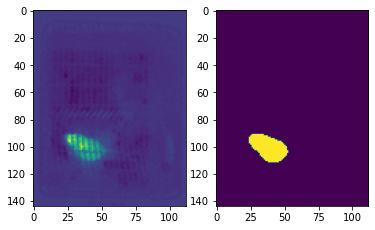

In [12]:
fig,ax = plt.subplots(1,2)
x,y = val_gen[100]
ax[0].imshow( x[0])
ax[1].imshow( model.predict(np.expand_dims( x[0],0 ) )[0]>0.6  )

8

In [14]:




cv2.namedWindow('img', cv2.WINDOW_NORMAL)

exit = False
for i in range(100):
    
    x,y = val_gen[i]
    for j in range(x.shape[0]):
        prediction = model.predict(np.expand_dims( x[0],0 ) )[0]>0.6
        x_rgb = cv2.cvtColor(x[0],cv2.COLOR_GRAY2RGB)
        prediction_rgb = cv2.cvtColor(prediction.astype('uint8'),cv2.COLOR_GRAY2RGB)
        fused = np.where(prediction_rgb, (255,255,0), x_rgb )
        
        cv2.imshow('img',fused)
        
        if cv2.waitKey(1) & 0xFF == ord('q'):
            exit= True
        
    if exit:
        break
cv2.destroyAllWindows()



In [156]:
cv2.destroyAllWindows()